# Exploratory Data Analysis - Senior Center Provider Data
---

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from senior_center_provider_data import scpd

In [4]:
scpd.columns

Index(['DFTA ID', 'Senior Center Name', 'Site Type', 'Borough',
       'Contract From Date', 'Contract To Date', 'Total FTEs', 'Total PTEs',
       'Months in HHS', 'Total Budget', 'Total Personnel Budget',
       'Total Expenses', 'Average Daily Clients', 'Kosher Meal Budget',
       'Non-Kosher Meal Budget', 'Total Meal Budget',
       'Average Meal Expenditure Per Client', 'Meal Prep Type',
       'Meal Prep For Other Centers', 'Total AIB-SCE-HPP Expenditures',
       'Average AIB-SCE-HPP Expenditures Per Client', 'Percent Utilization',
       'Latitude', 'Longitude', 'Total Employees', 'PTE Status',
       '% Budget Allocated for Personnel', '% Budget Allocated for Meals',
       '% Budget Used for AIB, SCE, & HPP Services'],
      dtype='object')

---
# Understanding the variables

## What are my grouping/categorical columns:
* `Site Type` (program site type: Neighborhood Senior Centers, Innovative Senior Centers, Senior Center)
* `Borough` (Brooklyn, Manhattan, Bronx, Queens, Staten Island)
* `Meal Prep Type` (program prepares meal in-house: Meal Prep On-Site, Catered, Both, Not Applicable)
* `Meal Prep For Other Centers` (program prepares meals for other sites: No, Yes)
* `PTE Status` (part-time employees: No PTEs, Has PTEs)

In [9]:
# Get the sample size (n) for each grouping variable
for col in ['Site Type', 'Borough', 'Meal Prep Type', 'Meal Prep For Other Centers', 'PTE Status']:
    print(f'{scpd.value_counts(col)}\n')

Site Type
Neighborhood Senior Centers    271
Innovative Senior Centers       18
Senior Center                    5
dtype: int64

Borough
Brooklyn         97
Manhattan        73
Bronx            56
Queens           56
Staten Island    12
dtype: int64

Meal Prep Type
Meal Prep On-Site    149
Catered              101
Not Applicable        31
Both                  13
dtype: int64

Meal Prep For Other Centers
No     250
Yes     44
dtype: int64

PTE Status
Has PTEs       149
Has No PTEs    145
dtype: int64



---
# Generating a quick-and-dirty correlation matrix to see what numerical variables might be related

In [67]:
numeric_cols = ['Total Employees', 'Total FTEs', 'Total PTEs', 'Total Budget', 'Total Personnel Budget', 'Total Meal Budget',
                '% Budget Allocated for Personnel', '% Budget Allocated for Meals', '% Budget Used for AIB, SCE, & HPP Services',
                'Average Daily Clients', 'Total Expenses', 'Total AIB-SCE-HPP Expenditures', 'Average Meal Expenditure Per Client',
                'Average AIB-SCE-HPP Expenditures Per Client']

# Compute a correlation matrix and assign to corr_matrix
corr_matrix = scpd[numeric_cols].corr('pearson')

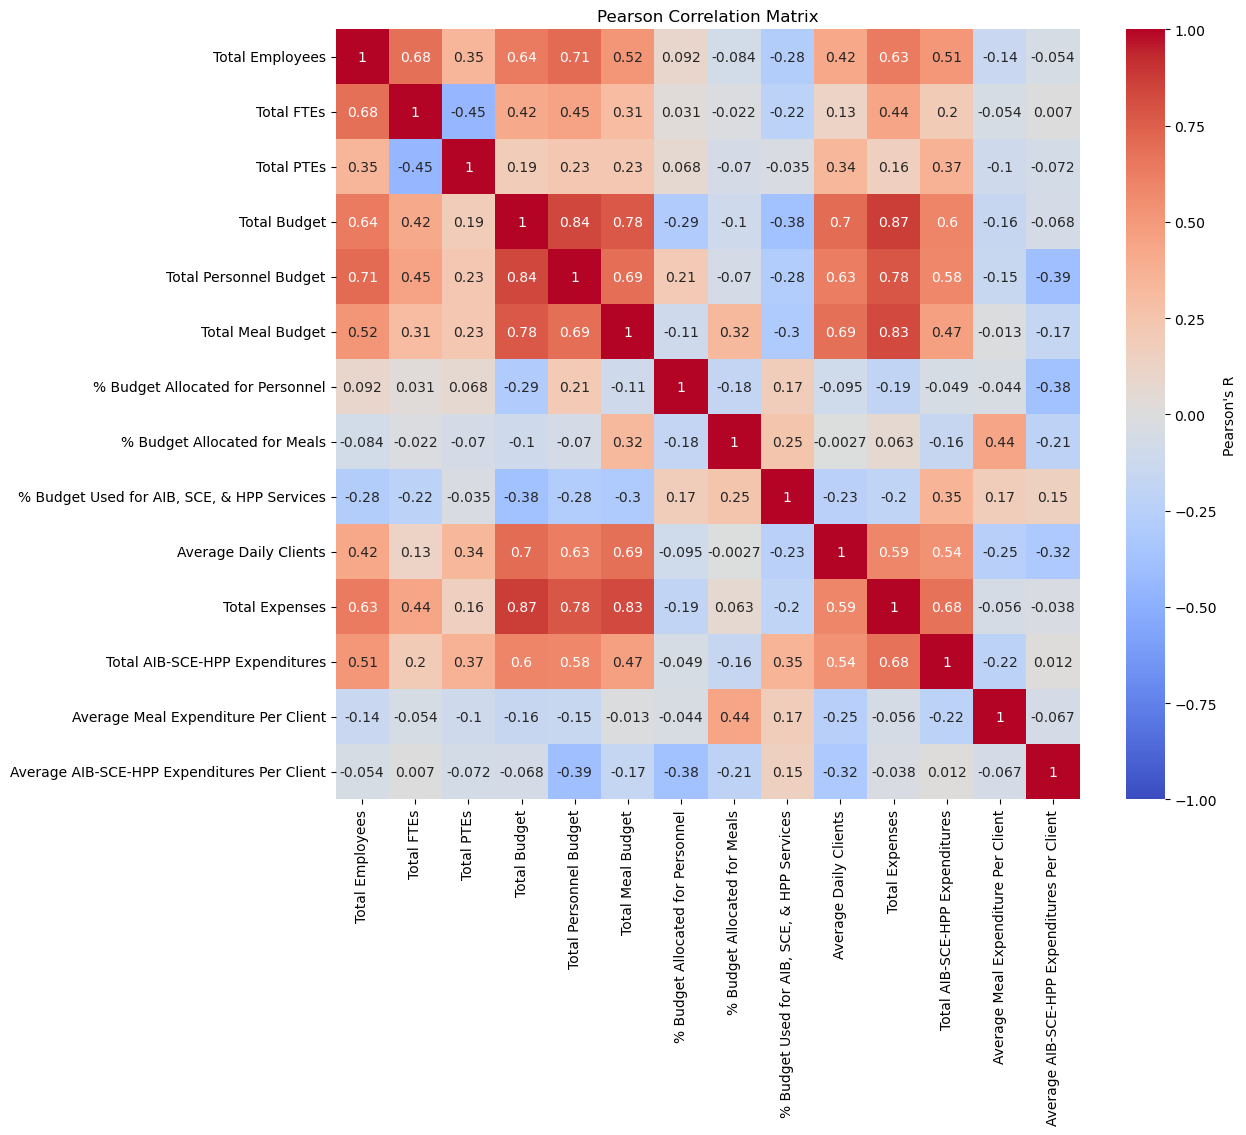

In [63]:
# Plot a heatmap from corr_matrix
plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, vmin = -1.0, vmax = 1.0, annot = True, cmap = 'coolwarm',
            cbar_kws = {
                'label': 'Pearson\'s R',
                'orientation': 'vertical'
            }).set(title = 'Pearson Correlation Matrix')

plt.show()

## Potential relationships to explore
* `Total Budget` x `Total Employees` (r = 0.64)
* `Total Budget` x `Total Meal Budget` (r = 0.78)

* `Total Personnel Budget` x `Total Budget` (r = 0.84)
* `Total Personnel Budget` x `Total Employees` (r = 0.71)
* `Total Personnel Budget` x `Total Meal Budget` (r = 0.69)

* `Average Daily Clients` x `Total Employees` (r = 0.42)
* `Average Daily Clients` x `Total Budget` (r = 0.7)
* `Average Daily Clients` x `Total Personnel Budget` (r = 0.63)
* `Average Daily Clients` x `Total Meal Budget` (r = 0.69)
* `Average Daily Clients` x `Total Expenses` (r = 0.59)

* `Total Expenses` x `Total Employees` (r = 0.63)
* `Total Expenses` x `Total Budget` (r = 0.87)
* `Total Expenses` x `Total Personnel Budget` (r = 0.78)
* `Total Expenses` x `Total Meal Budget` (r = 0.83)
* `Total Expenses` x `Total AIB-SCE-HPP Expenditures` (r = 0.68)

* `Average Meal Expenditure Per Client` x `% Budget Allocated for Meals` (r = 0.44)

---
# Grouping by Borough

## How many senior centers partnered with NYC Aging are in each borough?

In [13]:
print(f"The number of senior centers in each borough is:\n{scpd.value_counts('Borough')}")

The number of senior centers in each borough is:
Borough
Brooklyn         97
Manhattan        73
Bronx            56
Queens           56
Staten Island    12
dtype: int64


## What is the average number of employees (FTEs + PTEs) in senior centers for each borough?

In [26]:
scpd.groupby('Borough')['Total Employees'].describe()[['count', 'mean', 'std']]

,count,mean,std
Borough,,,
Bronx,56.0,8.178571,3.247976
Brooklyn,97.0,9.030928,4.590419
Manhattan,73.0,10.000000,4.493823
Queens,56.0,10.660714,5.254528
Staten Island,12.0,12.833333,5.024184


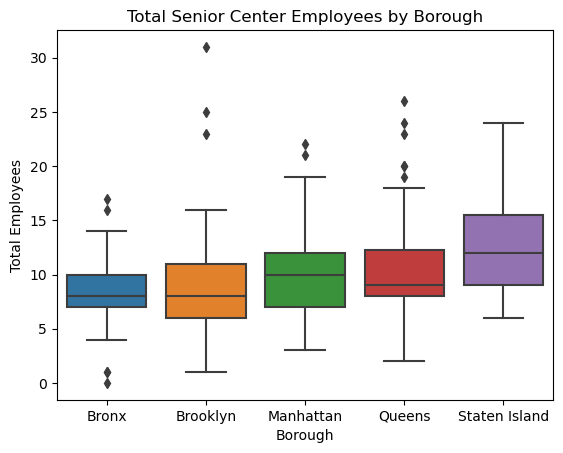

In [30]:
sns.boxplot(scpd, x = 'Borough', y = 'Total Employees').set(title = 'Total Senior Center Employees by Borough')
plt.show()

In [ ]:
sns.kdeplot(scpd, x = 'Borough', y = 'Total Employees').set(title = 'Total Senior Center Employees by Borough')
plt.show()

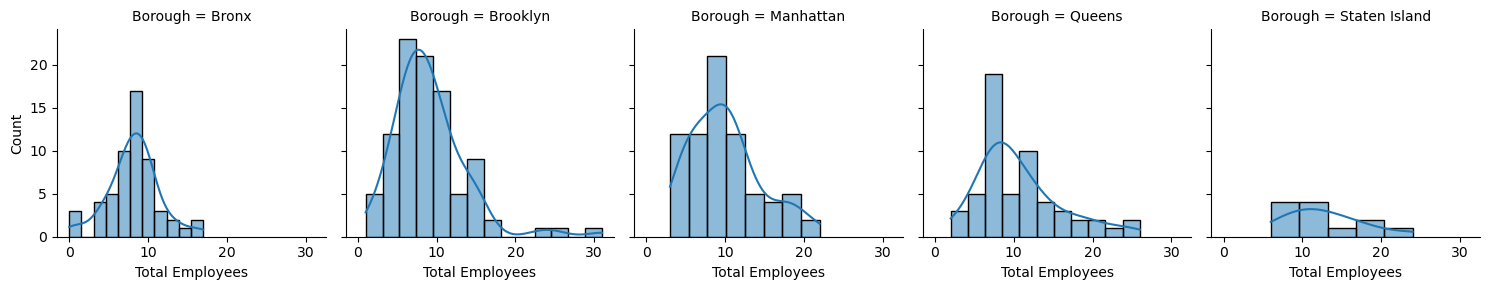

In [54]:
boroughs_facetgrid = sns.FacetGrid(scpd, col = 'Borough')
boroughs_facetgrid.map(sns.histplot, 'Total Employees', kde = True)
plt.show()

## What is the average number of full-time employees vs. part-time employees for each borough?

In [33]:
scpd.groupby(['Borough', 'PTE Status'])['Total Employees'].describe()[['count', 'mean', 'std']]

count       mean       std
Borough       PTE Status                             
Bronx         Has No PTEs   33.0   8.030303  2.579787
              Has PTEs      23.0   8.391304  4.075862
Brooklyn      Has No PTEs   54.0   8.611111  3.080166
              Has PTEs      43.0   9.558140  5.973363
Manhattan     Has No PTEs   26.0  10.038462  3.660391
              Has PTEs      47.0   9.978723  4.932101
Queens        Has No PTEs   30.0  10.366667  5.095524
              Has PTEs      26.0  11.000000  5.513620
Staten Island Has No PTEs    2.0   9.000000  0.000000
              Has PTEs      10.0  13.600000  5.189733

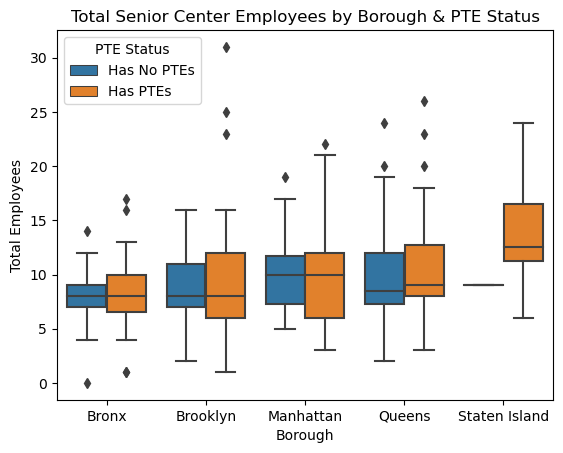

In [35]:
sns.boxplot(scpd, x = 'Borough', y = 'Total Employees', hue = 'PTE Status').set(title = 'Total Senior Center Employees by Borough & PTE Status')
plt.show()

## What is the average percent budget allocated for personnel in each borough?

In [41]:
scpd.groupby('Borough')['% Budget Allocated for Personnel'].describe()[['count', 'mean', 'std']]

,count,mean,std
Borough,,,
Bronx,55.0,0.609888,0.127937
Brooklyn,93.0,0.590367,0.105637
Manhattan,65.0,0.636221,0.122903
Queens,52.0,0.553821,0.168380
Staten Island,11.0,0.667704,0.135904


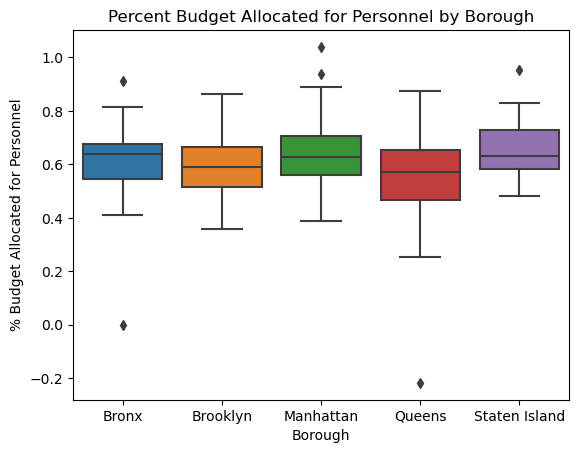

In [39]:
sns.boxplot(scpd, x = 'Borough', y = '% Budget Allocated for Personnel').set(title = 'Percent Budget Allocated for Personnel by Borough')
plt.show()

## Does the average percent budget allocated for personnel differ by PTE status?

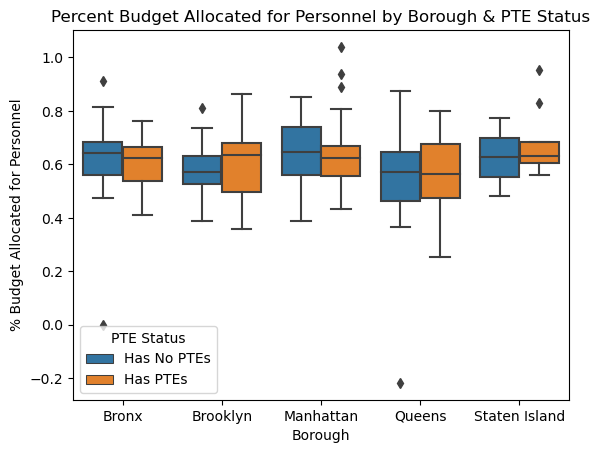

In [43]:
sns.boxplot(scpd, x = 'Borough', y = '% Budget Allocated for Personnel', hue = 'PTE Status').set(title = 'Percent Budget Allocated for Personnel by Borough & PTE Status')
plt.show()